# Simulation-Based Disaggregation of Unemployment Data
**Author:** Jiří Landsmann

This notebook demonstrates a simulation-driven pipeline for approximating fine-grained unemployment rates using auxiliary features and partial regional supervision.

The methodology integrates clustering, synthetic label simulation, and supervised learning models to predict district-level unemployment from region-level aggregates.


In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


## 1. Data Loading

We load three key datasets:
- **Voting data** (`combined_with_kraj_okres.xlsx`) providing auxiliary features at the district (Okres) level.
- **Unemployment data** (`nezamestnanost.csv`) summarizing official unemployment rates at the regional (Kraj) level.
- **Real district-level unemployment data** (`Formatted_Okres_Data.csv`) used solely for final model validation.

Normalization and cleaning steps ensure consistent naming conventions across datasets.


In [244]:
from sklearn.preprocessing import StandardScaler

# Load data
df_voting = pd.read_excel("DATA/combined_with_kraj_okres.xlsx")
df_okres_unemployment = pd.read_csv("DATA/nezamestnanost.csv")
df_okres_real = pd.read_csv("DATA/Formatted_Okres_Data.csv")

# Normalize names
df_voting["Okres"] = (
    df_voting["Okres"]
    .str.lower()
    .str.replace(" ", "")
    .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
)
df_voting["Kraj"] = (
    df_voting["Kraj"]
    .str.lower()
    .str.replace(" ", "")
    .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
)
df_okres_unemployment["Kraj"] = (
    df_okres_unemployment["Kraj"]
    .str.lower()
    .str.replace(" ", "")
    .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
)
df_okres_real["Okres"] = (
    df_okres_real["Okres"]
    .str.lower()
    .str.replace(" ", "")
    .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
)

# Extract kraj-level summary
df_kraj_summary = df_okres_unemployment.groupby("Kraj")["Podíl nezaměstnaných osob [%]"].mean().reset_index()
df_kraj_variance = df_okres_unemployment.groupby("Kraj")["Podíl nezaměstnaných osob [%]"].var().reset_index()
df_kraj_variance.rename(columns={"Podíl nezaměstnaných osob [%]": "Variance"}, inplace=True)

# Clean numeric voting data
df_voting["Hlasy abs."] = (
    df_voting["Hlasy abs."]
    .astype(str)
    .str.replace("\xa0", "", regex=True)
    .str.replace(",", ".", regex=True)
    .astype(float)
)

# Pivot voting data
df_voting_pivot = df_voting.pivot_table(
    index=["Kraj", "Okres"],
    columns="Volební strana",
    values="Hlasy abs.",
    aggfunc="sum",
    fill_value=0
).reset_index()

# Prepare features
features = df_voting_pivot.columns.drop(["Kraj", "Okres"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_voting_pivot[features])


## 2. Feature Engineering and Clustering

Voting data is aggregated by district and region, and standardized using a `StandardScaler`.

Dynamic clustering is applied:
- The number of clusters per region is adjusted based on unemployment variance.
- Districts are grouped into clusters to reflect internal socio-economic variation.

Simulated unemployment rates are generated per cluster, respecting region-level aggregates and controlling noise.


In [245]:
from sklearn.cluster import KMeans

# Apply dynamic clustering based on variance
clusters = []
for kraj in df_voting_pivot["Kraj"].unique():
    subset = df_voting_pivot[df_voting_pivot["Kraj"] == kraj].copy()
    kraj_variance = df_kraj_variance[df_kraj_variance["Kraj"] == kraj]["Variance"].values[0]

    # Determine number of samples
    num_samples = len(subset)

    # Set desired cluster count dynamically
    if kraj_variance < 0.5:
        desired_clusters = 3
    elif kraj_variance < 1.5:
        desired_clusters = 5
    else:
        desired_clusters = 7

    num_clusters = min(desired_clusters, num_samples)

    if num_clusters < 2:
        subset["Cluster"] = 0
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        subset["Cluster"] = kmeans.fit_predict(subset[features])

    kraj_unemployment = df_kraj_summary[df_kraj_summary["Kraj"] == kraj]["Podíl nezaměstnaných osob [%]"].values[0]

    # Use smaller noise for problematic regions
    if kraj in ["moravskoslezskykraj", "usteckykraj"]:
        std_dev = kraj_unemployment * 0.04
    else:
        std_dev = kraj_unemployment * 0.04

    subset["Simulated_Unemployment"] = np.random.normal(loc=kraj_unemployment, scale=std_dev, size=len(subset))
    subset["Simulated_Unemployment"] = subset["Simulated_Unemployment"].clip(lower=0)

    # Rescale to real kraj mean to avoid bias drift
    sim_mean = subset["Simulated_Unemployment"].mean()
    if sim_mean > 0:
        correction = kraj_unemployment / sim_mean
        subset["Simulated_Unemployment"] *= correction

    clusters.append(subset)

df_clustered = pd.concat(clusters)


## 3. Model Training

Four supervised regression models are trained on the simulated district-level data:
- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient boosting Regressor

Models learn to map auxiliary features and cluster labels to predicted unemployment rates.


In [246]:
from sklearn.ensemble import GradientBoostingRegressor

# Add Cluster as a feature to model
features = df_clustered.columns.drop([
    "Kraj", "Okres", "Simulated_Unemployment"
])

# Train models
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

X_train = df_clustered[features]
y_train = df_clustered["Simulated_Unemployment"]

for model_name, model in models.items():
    model.fit(X_train, y_train)
    df_clustered[f"{model_name}_Prediction"] = model.predict(X_train)


## 4. Model Evaluation and Validation

Predictions are validated against real district-level unemployment rates.

Metrics:
- **Mean Absolute Error (MAE)** for overall prediction accuracy.
- (Optional) Pearson correlation to assess monotonic relationships.

Additionally, the simulated unemployment from clustering alone is evaluated as a baseline.


In [247]:
# Merge with real Okres unemployment data for validation
df_final = pd.merge(df_clustered, df_okres_real, on="Okres", how="left")
df_final.rename(columns={"Podíl nezaměstnaných osob [%]": "Real_Unemployment"}, inplace=True)

# Compute MAE for models (handling inconsistent lengths)
for model_name in models.keys():
    valid_rows = df_final[["Real_Unemployment", f"{model_name}_Prediction"]].dropna()
    mae = mean_absolute_error(valid_rows["Real_Unemployment"], valid_rows[f"{model_name}_Prediction"])
    print(f"{model_name} MAE: {mae:.4f}")

# Compute MAE for clustering-based predictions (ensuring consistent data length)
valid_clustering = df_final[["Real_Unemployment", "Simulated_Unemployment"]].dropna()
mae_clustering = mean_absolute_error(valid_clustering["Real_Unemployment"], valid_clustering["Simulated_Unemployment"])
print(f"Mean Absolute Error (MAE) for Clustering Only: {mae_clustering:.4f}")

LinearRegression MAE: 0.6743
DecisionTree MAE: 0.6743
RandomForest MAE: 0.7324
GradientBoosting MAE: 0.6796
Mean Absolute Error (MAE) for Clustering Only: 0.6743


## 5. Saving Detailed Results

The final dataset, including:
- District identifiers
- Clusters
- Simulated unemployment
- Model predictions
- Real unemployment values

...is saved to `final_unemployment_predictions_with_clusters.csv` for further analysis and visualization.


In [248]:
cols = [
    "Kraj",
    "Okres",
    "Real_Unemployment",
    "Simulated_Unemployment",
    "LinearRegression_Prediction",
    "DecisionTree_Prediction",
    "RandomForest_Prediction",
    "GradientBoosting_Prediction",
]

# filtrovat jen existující sloupce, kdybys náhodou některý model neměl
cols = [c for c in cols if c in df_final.columns]

detailed_results = df_final[cols]

print("Detailed prediction results:")
print(detailed_results.head())


Detailed prediction results:
               Kraj             Okres  Real_Unemployment  \
0  hlavnimestopraha  hlavnimestopraha                3.1   
1     jihoceskykraj   ceskebudejovice                2.4   
2     jihoceskykraj      ceskykrumlov                3.5   
3     jihoceskykraj  jindrichuvhradec                2.0   
4     jihoceskykraj             pisek                2.4   

   Simulated_Unemployment  LinearRegression_Prediction  \
0                3.100000                     3.100000   
1                2.616713                     2.616713   
2                2.678824                     2.678824   
3                2.646672                     2.646672   
4                2.583242                     2.583242   

   DecisionTree_Prediction  RandomForest_Prediction  \
0                 3.100000                 3.327322   
1                 2.616713                 2.961404   
2                 2.678824                 2.892002   
3                 2.646672               

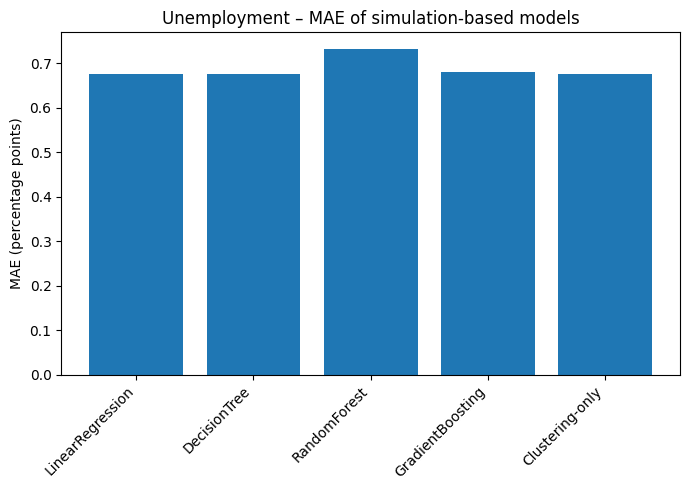

In [249]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

models_unemp = ["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting", "Clustering-only"]
mae_unemp = []

for model_name in models_unemp:
    if model_name == "Clustering-only":
        # čistě simulovaná nezaměstnanost z clusterů
        valid = df_final[["Real_Unemployment", "Simulated_Unemployment"]].dropna()
        y_true = valid["Real_Unemployment"]
        y_pred = valid["Simulated_Unemployment"]
    else:
        col = f"{model_name}_Prediction"
        if col not in df_final.columns:
            raise ValueError(f"Column {col} not found in df_final")
        valid = df_final[["Real_Unemployment", col]].dropna()
        y_true = valid["Real_Unemployment"]
        y_pred = valid[col]

    mae = mean_absolute_error(y_true, y_pred)
    mae_unemp.append(mae)

plt.figure(figsize=(7, 5))
plt.bar(models_unemp, mae_unemp)
plt.xticks(rotation=45, ha="right")
plt.ylabel("MAE (percentage points)")
plt.title("Unemployment – MAE of simulation-based models")
plt.tight_layout()
plt.show()


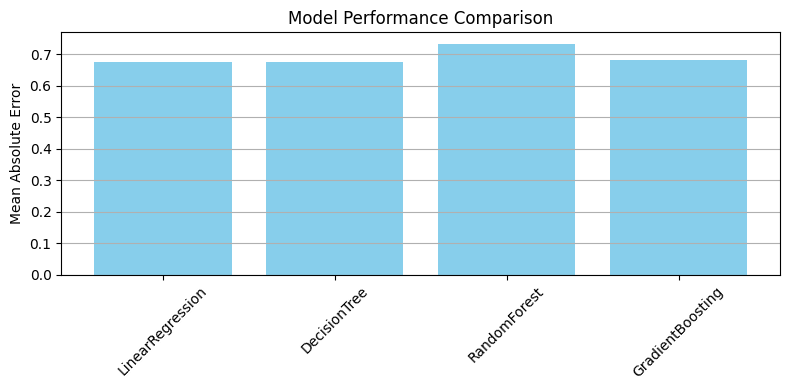

In [250]:
# Calculate and store MAEs
mae_scores = {}

for model_name in models.keys():
    valid_rows = df_final[["Real_Unemployment", f"{model_name}_Prediction"]].dropna()
    mae = mean_absolute_error(valid_rows["Real_Unemployment"], valid_rows[f"{model_name}_Prediction"])
    mae_scores[model_name] = mae

# (Optional) Also add simulated baseline
# valid_clustering = df_final[["Real_Unemployment", "Simulated_Unemployment"]].dropna()
# mae_scores["Simulated Baseline"] = mean_absolute_error(valid_clustering["Real_Unemployment"], valid_clustering["Simulated_Unemployment"])


import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(mae_scores.keys(), mae_scores.values(), color='skyblue')
plt.ylabel("Mean Absolute Error")
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


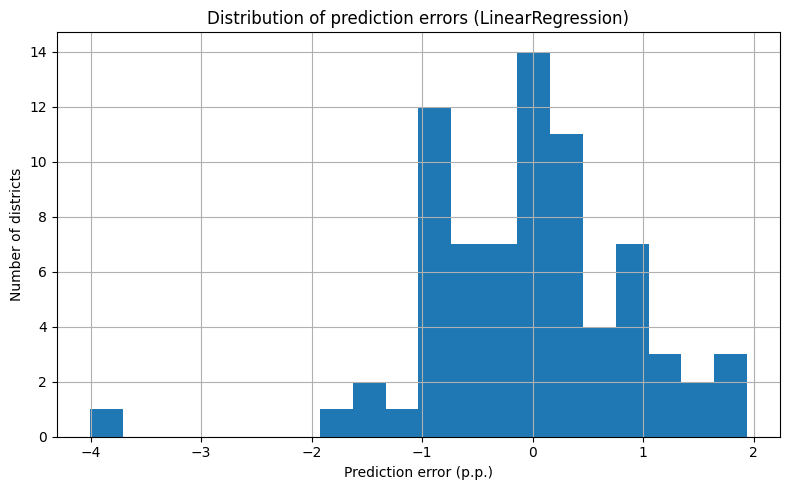

In [251]:
errors = df_final["LinearRegression_Prediction"] - df_final["Real_Unemployment"]

plt.figure(figsize=(8,5))
plt.hist(errors, bins=20)
plt.xlabel("Prediction error (p.p.)")
plt.ylabel("Number of districts")
plt.title("Distribution of prediction errors (LinearRegression)")
plt.grid(True)
plt.tight_layout()
plt.show()


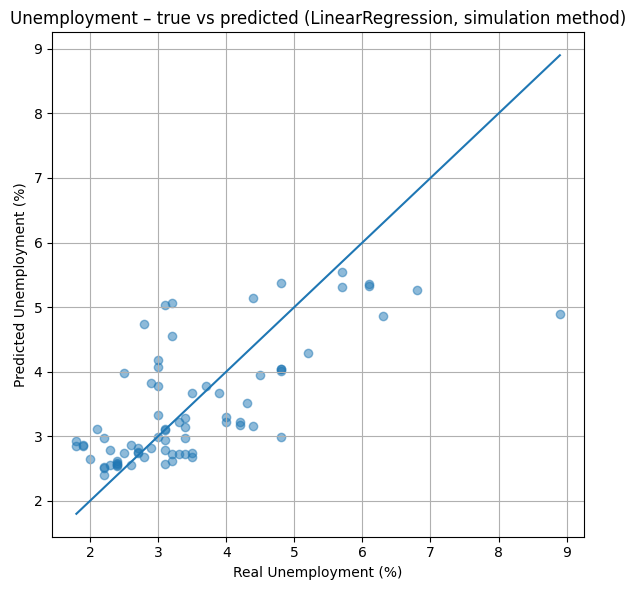

In [252]:
real = df_final["Real_Unemployment"]
pred = df_final["LinearRegression_Prediction"]

min_val = min(real.min(), pred.min())
max_val = max(real.max(), pred.max())

plt.figure(figsize=(6, 6))
plt.scatter(real, pred, alpha=0.5)
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("Real Unemployment (%)")
plt.ylabel("Predicted Unemployment (%)")
plt.title("Unemployment – true vs predicted (LinearRegression, simulation method)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [253]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Create results DataFrame for simulation-based models
results_df = df_final[[
    "Okres",
    "Real_Unemployment"
]].copy()

# Rename for consistency
results_df = results_df.rename(columns={"Real_Unemployment": "Actual_Unemployment"})

# Add predictions from all models
results_df["Predicted_Simulated"] = df_final["Simulated_Unemployment"]
results_df["Predicted_Linear_Regression"] = df_final["LinearRegression_Prediction"]
results_df["Predicted_Decision_Tree"] = df_final["DecisionTree_Prediction"]
results_df["Predicted_Random_Forest"] = df_final["RandomForest_Prediction"]
results_df["Predicted_Gradient_Boosting"] = df_final["GradientBoosting_Prediction"]

# Calculate absolute errors
results_df["AbsError_Simulated"] = abs(results_df["Predicted_Simulated"] - results_df["Actual_Unemployment"])
results_df["AbsError_Linear_Regression"] = abs(results_df["Predicted_Linear_Regression"] - results_df["Actual_Unemployment"])
results_df["AbsError_Decision_Tree"] = abs(results_df["Predicted_Decision_Tree"] - results_df["Actual_Unemployment"])
results_df["AbsError_Random_Forest"] = abs(results_df["Predicted_Random_Forest"] - results_df["Actual_Unemployment"])
results_df["AbsError_Gradient_Boosting"] = abs(results_df["Predicted_Gradient_Boosting"] - results_df["Actual_Unemployment"])

# Save to CSV
output_filename = "okres_unemployment_predictions_simulation_models.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8')

print(f"✅ Results saved to {output_filename}")
print(f"Total okresy: {len(results_df)}")
print(f"Columns: {list(results_df.columns)}")

# Calculate and display MAE summary
print("=" * 60)
print("SUMMARY - Mean Absolute Error by Model:")
print("=" * 60)

mae_simulated = results_df["AbsError_Simulated"].mean()
mae_lr = results_df["AbsError_Linear_Regression"].mean()
mae_dt = results_df["AbsError_Decision_Tree"].mean()
mae_rf = results_df["AbsError_Random_Forest"].mean()
mae_gb = results_df["AbsError_Gradient_Boosting"].mean()

print(f"Simulated (Clustering) : {mae_simulated:.4f}")
print(f"Linear_Regression      : {mae_lr:.4f}")
print(f"Decision_Tree          : {mae_dt:.4f}")
print(f"Random_Forest          : {mae_rf:.4f}")
print(f"Gradient_Boosting      : {mae_gb:.4f}")
print("=" * 60)

print("Preview of results:")
print("=" * 60)
print(results_df.head(10).to_string())

✅ Results saved to okres_unemployment_predictions_simulation_models.csv
Total okresy: 77
Columns: ['Okres', 'Actual_Unemployment', 'Predicted_Simulated', 'Predicted_Linear_Regression', 'Predicted_Decision_Tree', 'Predicted_Random_Forest', 'Predicted_Gradient_Boosting', 'AbsError_Simulated', 'AbsError_Linear_Regression', 'AbsError_Decision_Tree', 'AbsError_Random_Forest', 'AbsError_Gradient_Boosting']
SUMMARY - Mean Absolute Error by Model:
Simulated (Clustering) : 0.6743
Linear_Regression      : 0.6743
Decision_Tree          : 0.6743
Random_Forest          : 0.7324
Gradient_Boosting      : 0.6796
Preview of results:
              Okres  Actual_Unemployment  Predicted_Simulated  Predicted_Linear_Regression  Predicted_Decision_Tree  Predicted_Random_Forest  Predicted_Gradient_Boosting  AbsError_Simulated  AbsError_Linear_Regression  AbsError_Decision_Tree  AbsError_Random_Forest  AbsError_Gradient_Boosting
0  hlavnimestopraha                  3.1             3.100000                     

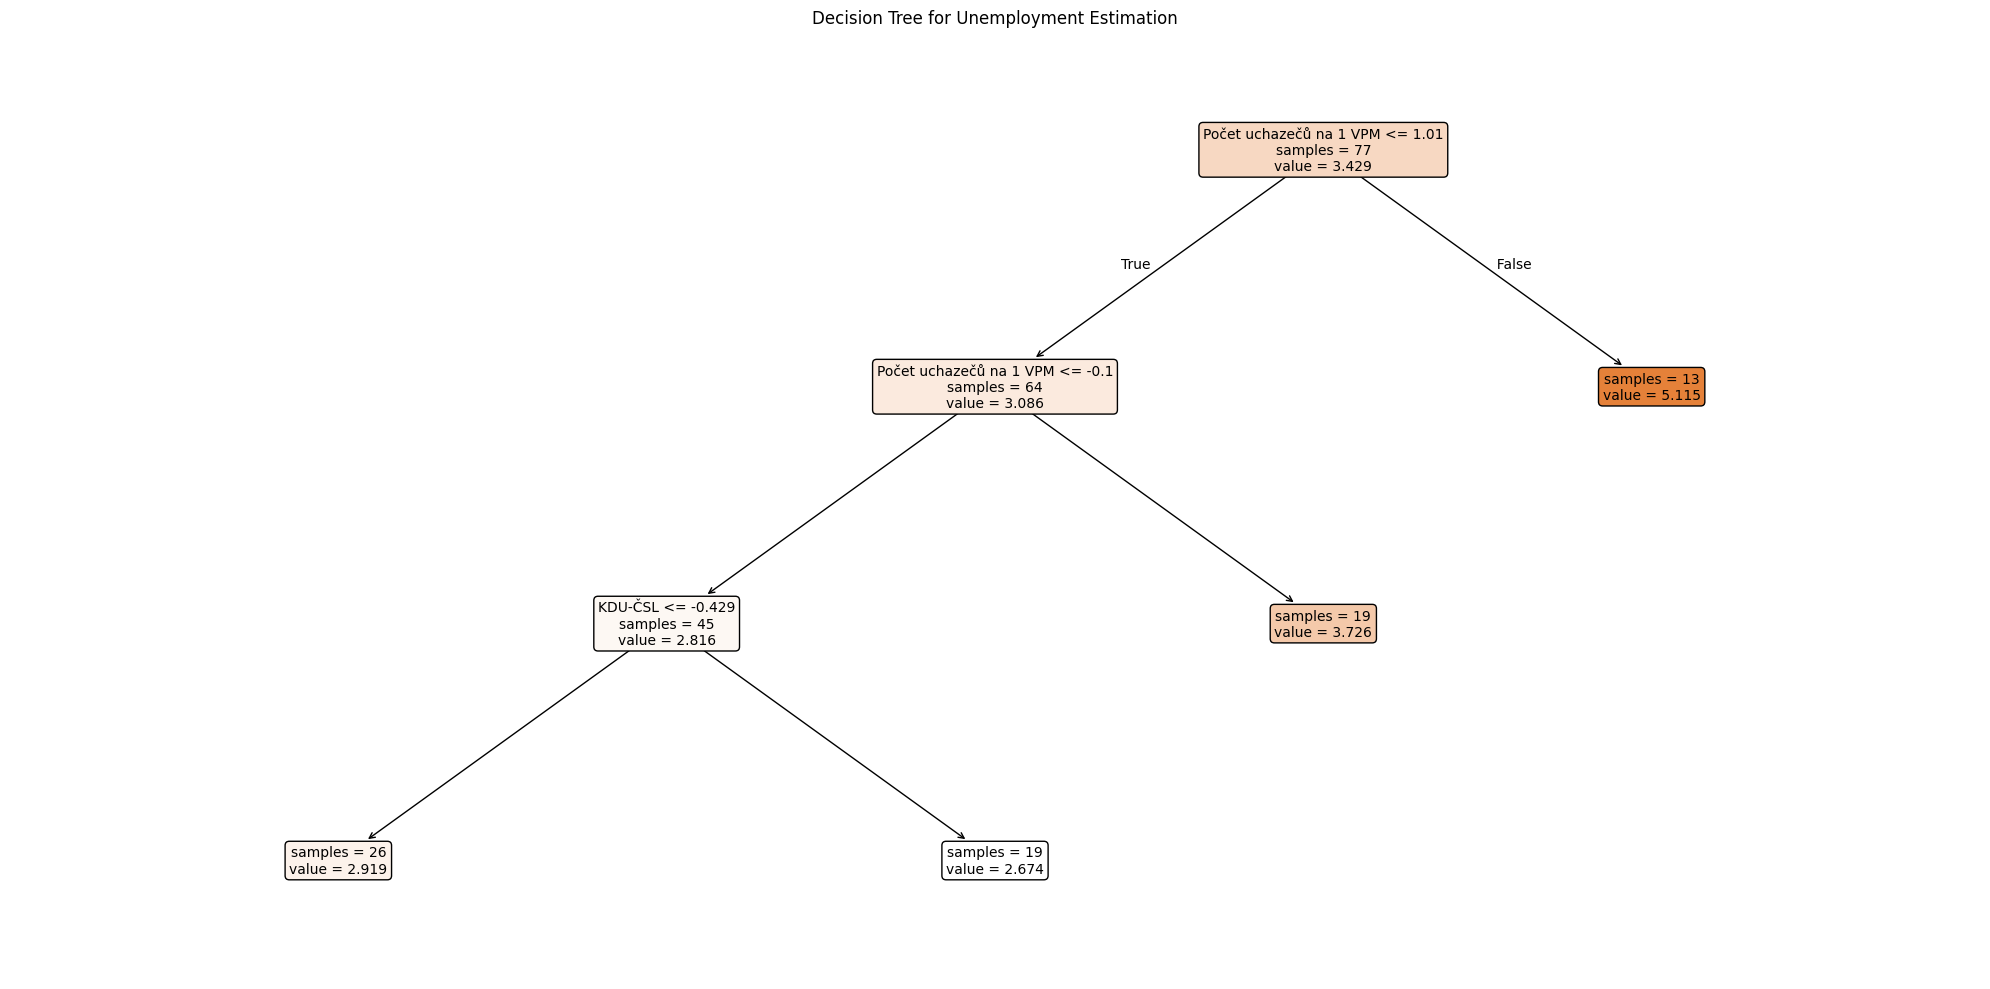


Feature Importance for Unemployment Estimation:
                                 feature  importance
391              Počet uchazečů na 1 VPM    0.988232
31                               KDU-ČSL    0.011768
8                           COEXISTENTIA    0.000000
0           A DOST! PRO LEPŠÍ BUDOUCNOST    0.000000
1                               ANO 2011    0.000000
2                    Alternativa pro Vás    0.000000
3    BEZPEČNOST, ODPOVĚDNOST, SOLIDARITA    0.000000
4                          Bezpečná země    0.000000
5                              Brno Plus    0.000000
376                          VÝCHODOČEŠI    0.000000
Decision Tree Interpretation:
If Počet uchazečů na 1 VPM <= 1.0100:
  If Počet uchazečů na 1 VPM <= -0.1000:
    If KDU-ČSL <= -0.4293:
      Predict Unemployment: 2.9192
    Else KDU-ČSL > -0.4293:
      Predict Unemployment: 2.6737
  Else Počet uchazečů na 1 VPM > -0.1000:
    Predict Unemployment: 3.7263
Else Počet uchazečů na 1 VPM > 1.0100:
  Predict Unemployme

In [254]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
voting_file = "./DATA/combined_with_kraj_okres.xlsx"
unemployment_file = "./DATA/nezamestnanost.csv"
real_okres_file = "./DATA/Formatted_Okres_Data.csv"

# Read datasets
df_voting = pd.read_excel(voting_file)
df_real = pd.read_csv(real_okres_file)
df_kraj = pd.read_csv(unemployment_file)

# Normalize names
for df in [df_voting, df_real, df_kraj]:
    if "Okres" in df.columns:
        df["Okres"] = (
            df["Okres"].str.lower().str.replace(" ", "")
            .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
        )
    if "Kraj" in df.columns:
        df["Kraj"] = (
            df["Kraj"].str.lower().str.replace(" ", "")
            .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
        )

# Clean voting numbers
df_voting["Votes_Absolute"] = (
    df_voting["Hlasy abs."].astype(str)
    .str.replace("\xa0", "", regex=True)
    .str.replace(",", ".", regex=True)
    .astype(float)
)

# Pivot voting results table
df_voting_pivot = df_voting.pivot_table(
    index=["Kraj", "Okres"],
    columns="Volební strana",
    values="Votes_Absolute",
    aggfunc="sum",
    fill_value=0
).reset_index()

# Merge with unemployment data
df_voting_pivot = pd.merge(df_voting_pivot, df_kraj, on="Kraj", how="left")
df_voting_pivot.rename(columns={"Podíl nezaměstnaných osob [%]": "Regional_Unemployment"}, inplace=True)

# Prepare features
exclude_columns = ["Kraj", "Okres", "Regional_Unemployment"]
X = df_voting_pivot.drop(columns=exclude_columns)
y = df_voting_pivot["Regional_Unemployment"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train interpretable decision tree
dt_model = DecisionTreeRegressor(
    max_depth=3,  # Limit depth for interpretability
    min_samples_leaf=10,  # Minimum samples in leaf
    random_state=42
)
dt_model.fit(X_scaled, y)

# Visualize tree
plt.figure(figsize=(20,10))
plot_tree(dt_model,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          fontsize=10,
          impurity=False)
plt.title("Decision Tree for Unemployment Estimation")
plt.tight_layout()
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance for Unemployment Estimation:")
print(feature_importance.head(10))

# Additional interpretability: sample decision paths
def interpret_tree_path(tree, feature_names):
    """
    Generate interpretable descriptions of decision paths
    """
    def recurse_tree(node, depth=0):
        indent = "  " * depth
        if tree.feature[node] != -2:  # Not a leaf node
            feature = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]
            print(f"{indent}If {feature} <= {threshold:.4f}:")
            recurse_tree(tree.children_left[node], depth + 1)
            print(f"{indent}Else {feature} > {threshold:.4f}:")
            recurse_tree(tree.children_right[node], depth + 1)
        else:
            value = tree.value[node][0][0]
            print(f"{indent}Predict Unemployment: {value:.4f}")

    print("Decision Tree Interpretation:")
    recurse_tree(0)

# Print interpretable decision paths
interpret_tree_path(dt_model.tree_, X.columns)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import r2_score

# Create directories if they don't exist
os.makedirs('plotsMethod', exist_ok=True)

# Read the CSV file
df = pd.read_csv('okres_unemployment_predictions_simulation_models.csv')

def safe_r2_score(y_true, y_pred):
    try:
        mask = ~(np.isnan(y_true) | np.isnan(y_pred) | np.isinf(y_true) | np.isinf(y_pred))
        return r2_score(y_true[mask], y_pred[mask])
    except Exception as e:
        print(f"R² calculation error: {e}")
        return np.nan

def plot_prediction_comparison(df, actual_column, predicted_columns, method_type='Method',
                                figsize=(20, 10),
                                dpi=300):
    plt.figure(figsize=figsize, dpi=dpi)

    # Create subplots for each model
    for i, (model, predicted_column) in enumerate(predicted_columns.items(), 1):
        plt.subplot(2, 2, i)

        # Remove any potential NaN values
        valid_data = df.dropna(subset=[actual_column, predicted_column])

        # Scatter plot
        plt.scatter(valid_data[actual_column], valid_data[predicted_column],
                    alpha=0.7, s=30)  # Reduced marker size

        # Diagonal line
        min_val = min(valid_data[actual_column].min(), valid_data[predicted_column].min())
        max_val = max(valid_data[actual_column].max(), valid_data[predicted_column].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

        plt.title(f'{model} Prediction vs Actual', fontsize=14)
        plt.xlabel('Actual Values', fontsize=12)
        plt.ylabel('Predicted Values', fontsize=12)

        # Calculate metrics
        mae = np.mean(np.abs(valid_data[actual_column] - valid_data[predicted_column]))
        r2 = safe_r2_score(valid_data[actual_column], valid_data[predicted_column])

        plt.annotate(f'MAE: {mae:.2f}\nR²: {r2:.2f}',
                     xy=(0.05, 0.95),
                     xycoords='axes fraction',
                     fontsize=12)

        # Improve tick label readability
        plt.tick_params(axis='both', which='major', labelsize=6)

        # Add grid for better readability
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.savefig(os.path.join('plotsMethod', 'method_prediction_comparison.png'),
                dpi=dpi, bbox_inches='tight')
    plt.close()

# Define predicted columns for Method
method_predicted_columns = {
    'Linear Regression': 'Predicted_Linear_Regression',
    'Decision Tree': 'Predicted_Decision_Tree',
    'Random Forest': 'Predicted_Random_Forest',
    'Gradient Boosting': 'Predicted_Gradient_Boosting'
}

# Actual column name
actual_column = 'Actual_Unemployment'

# Generate plots and analysis for Method
plot_prediction_comparison(df, actual_column, method_predicted_columns, 'Method')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import r2_score

# Create directories if they don't exist
os.makedirs('plotsMethod', exist_ok=True)

# Read the CSV file
df = pd.read_csv('okres_unemployment_predictions_simulation_models.csv')

def safe_r2_score(y_true, y_pred):
    try:
        # Remove NaN values
        mask = ~(np.isnan(y_true) | np.isnan(y_pred))
        y_true_clean = y_true[mask]
        y_pred_clean = y_pred[mask]

        return r2_score(y_true_clean, y_pred_clean)
    except Exception as e:
        print(f"R² calculation error: {e}")
        return np.nan

def plot_error_distribution(df, actual_column, predicted_columns, method_type='Method',
                             figsize=(20, 10),
                             dpi=300):
    plt.figure(figsize=figsize, dpi=dpi)

    # Calculate and plot absolute errors
    for i, (model, predicted_column) in enumerate(predicted_columns.items(), 1):
        plt.subplot(2, 2, i)

        # Drop rows with NaN values
        valid_data = df.dropna(subset=[actual_column, predicted_column])

        # Calculate absolute errors
        abs_errors = np.abs(valid_data[actual_column] - valid_data[predicted_column])

        # Plot error distribution
        sns.histplot(abs_errors, kde=True)

        # Calculate statistical metrics
        mean_error = np.mean(abs_errors)
        r2 = safe_r2_score(valid_data[actual_column], valid_data[predicted_column])

        # Safe median calculation
        try:
            median_error = np.median(abs_errors)
            median_text = f'Median Error: {median_error:.2f}\n'
        except Exception as e:
            median_text = f'Median Error: Not calculable ({e})\n'

        plt.title(f'{model} Absolute Error Distribution', fontsize=14)
        plt.xlabel('Absolute Error', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)

        # Annotate with statistical information
        plt.annotate(f'Mean Error: {mean_error:.2f}\n{median_text}',
                     xy=(0.05, 0.95),
                     xycoords='axes fraction',
                     fontsize=12,
                     verticalalignment='top')

        # Improve tick label readability
        plt.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.savefig(os.path.join('plotsMethod', 'method_error_distribution.png'),
                dpi=dpi, bbox_inches='tight')
    plt.close()

# Define predicted columns for Method
method_predicted_columns = {
    'Linear Regression': 'Predicted_Linear_Regression',
    'Decision Tree': 'Predicted_Decision_Tree',
    'Random Forest': 'Predicted_Random_Forest',
    'Gradient Boosting': 'Predicted_Gradient_Boosting'
}

# Actual column name
actual_column = 'Actual_Unemployment'

# Generate error distribution plot for Method
plot_error_distribution(df, actual_column, method_predicted_columns, 'Method')

# Optional: Print detailed error statistics
print("\nError Statistics:")
for model, predicted_column in method_predicted_columns.items():
    # Drop rows with NaN values
    valid_data = df.dropna(subset=[actual_column, predicted_column])

    abs_errors = np.abs(valid_data[actual_column] - valid_data[predicted_column])
    r2 = safe_r2_score(valid_data[actual_column], valid_data[predicted_column])

    print(f"\n{model}:")
    print(f"  Mean Absolute Error: {np.mean(abs_errors):.4f}")
    print(f"  Median Absolute Error: {np.median(abs_errors):.4f}")
    print(f"  Max Absolute Error: {np.max(abs_errors):.4f}")
    print(f"  Standard Deviation of Error: {np.std(abs_errors):.4f}")
    print(f"  R² Score: {r2:.4f}")


Error Statistics:

Linear Regression:
  Mean Absolute Error: 0.6743
  Median Absolute Error: 0.5793
  Max Absolute Error: 4.0077
  Standard Deviation of Error: 0.6289
  R² Score: 0.5019

Decision Tree:
  Mean Absolute Error: 0.6743
  Median Absolute Error: 0.5793
  Max Absolute Error: 4.0077
  Standard Deviation of Error: 0.6289
  R² Score: 0.5019

Random Forest:
  Mean Absolute Error: 0.7324
  Median Absolute Error: 0.5938
  Max Absolute Error: 4.4007
  Standard Deviation of Error: 0.6164
  R² Score: 0.4632

Gradient Boosting:
  Mean Absolute Error: 0.6796
  Median Absolute Error: 0.5652
  Max Absolute Error: 4.0212
  Standard Deviation of Error: 0.6246
  R² Score: 0.5009
